In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn

In [128]:
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

In [129]:
X, y = make_circles(n_samples=100, noise=0.1, random_state=1)

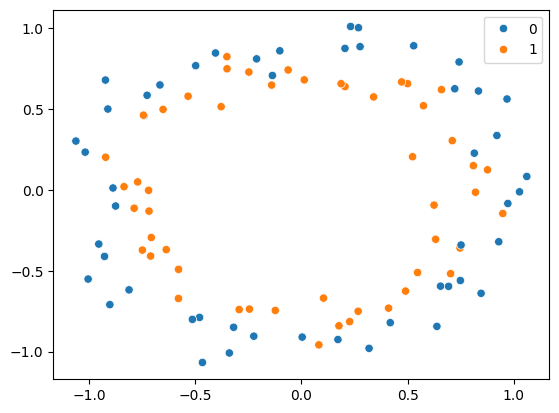

In [130]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)
plt.show()

In [131]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [132]:
# turning data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [134]:
X_train.shape

torch.Size([80, 2])

In [135]:
class Early_stopping(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, X):
        return self.linear_layer_stack(X)
model = Early_stopping().to(device)

In [136]:
model

Early_stopping(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [137]:
model.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[-0.6859,  0.4806],
                      [-0.3145,  0.1932],
                      [-0.1039,  0.3862],
                      [-0.2246,  0.6010],
                      [ 0.6150, -0.2386],
                      [ 0.3756,  0.5144],
                      [ 0.5278, -0.0458],
                      [-0.3535,  0.6359],
                      [ 0.2249,  0.6668],
                      [-0.4571,  0.1502],
                      [-0.2775, -0.4206],
                      [-0.4584,  0.2629],
                      [-0.0278,  0.4221],
                      [ 0.2924, -0.0548],
                      [-0.5936,  0.5144],
                      [-0.2275, -0.1943],
                      [-0.4371, -0.5803],
                      [-0.4534,  0.0065],
                      [-0.1673,  0.1345],
                      [ 0.1465,  0.2380],
                      [-0.3322, -0.1494],
                      [ 0.6664,  0.1819],
                      [ 0.6801,

In [138]:
total_params = sum(
	param.numel() for param in model.parameters()
)
total_params

1025

In [139]:
# loss fn and optimizer
loss_fc = nn.BCELoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                            lr = 0.001)

In [140]:
epochs = 3500

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

  model.train()

  # forward pass
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate the loss/accuarcy
  loss = loss_fc(y_logits, y_train)

  # optimizer zero grad
  optimizer.zero_grad()

  # backpropagation
  loss.backward()

  # optimizer step (perform gradient descent)
  optimizer.step()

  # testing
  model.eval()
  with torch.inference_mode():

    # forward pass
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate the loss/accuarcy
    test_loss = loss_fc(test_logits, y_test)


# lets print out what is happening
    if epoch % 100 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | Loss: {loss}")

Epoch: 0 | Loss: 0.6929758787155151
Epoch: 100 | Loss: 0.5440540313720703
Epoch: 200 | Loss: 0.39686304330825806
Epoch: 300 | Loss: 0.3052451014518738
Epoch: 400 | Loss: 0.2545902729034424
Epoch: 500 | Loss: 0.2238142192363739
Epoch: 600 | Loss: 0.20221559703350067
Epoch: 700 | Loss: 0.18717655539512634
Epoch: 800 | Loss: 0.17648498713970184
Epoch: 900 | Loss: 0.16867950558662415
Epoch: 1000 | Loss: 0.16285374760627747
Epoch: 1100 | Loss: 0.15825405716896057
Epoch: 1200 | Loss: 0.15472841262817383
Epoch: 1300 | Loss: 0.15207171440124512
Epoch: 1400 | Loss: 0.14999642968177795
Epoch: 1500 | Loss: 0.14833635091781616
Epoch: 1600 | Loss: 0.1468665897846222
Epoch: 1700 | Loss: 0.1457357257604599
Epoch: 1800 | Loss: 0.1447225660085678
Epoch: 1900 | Loss: 0.1438467800617218
Epoch: 2000 | Loss: 0.1430162787437439
Epoch: 2100 | Loss: 0.14215870201587677
Epoch: 2200 | Loss: 0.1413475126028061
Epoch: 2300 | Loss: 0.14055085182189941
Epoch: 2400 | Loss: 0.13979190587997437
Epoch: 2500 | Loss: 0.1

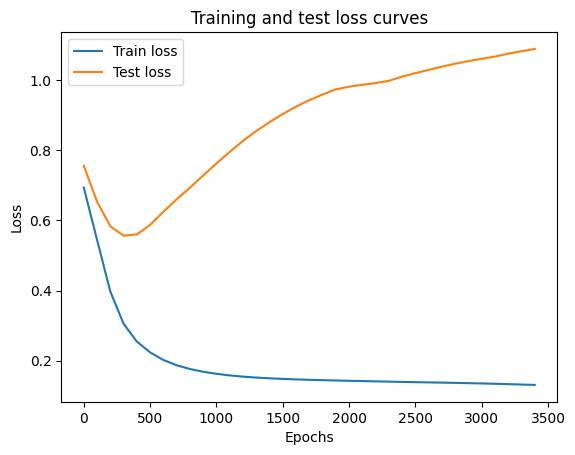

In [141]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

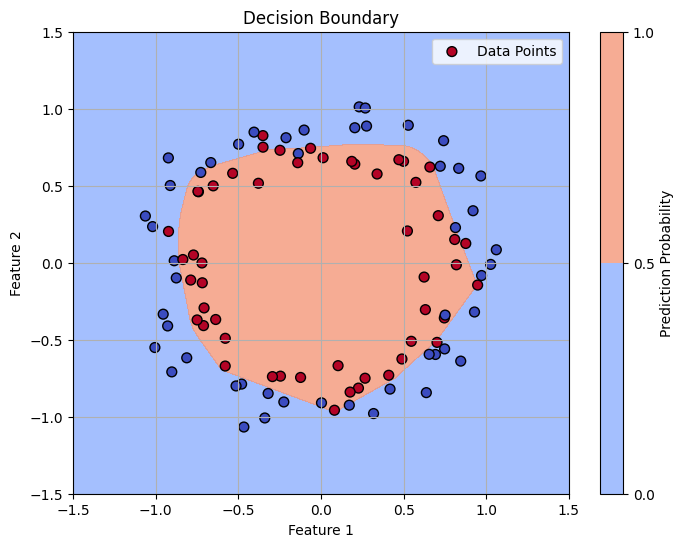

In [142]:
# 1. Generate a grid of points
x1_range = np.linspace(-1.5, 1.5, 200)
x2_range = np.linspace(-1.5, 1.5, 200)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# 2. Predict probabilities for the grid points
with torch.no_grad():
    grid_preds = model(grid_tensor).numpy()

# 3. Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(x1_grid, x2_grid, grid_preds.reshape(x1_grid.shape), levels=[0, 0.5, 1], alpha=0.8, cmap='coolwarm')
plt.colorbar(label='Prediction Probability')

# 4. Overlay the data points
plt.scatter(X[:, 0], X[:, 1], c=y.numpy().ravel(), edgecolor='k', cmap='coolwarm', s=50, label='Data Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary')
plt.legend()
plt.grid()
plt.show()

## Early Stopping

In [143]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=5, delta=0, save_path="checkpoint.pth"):
        """
        Args:
            patience (int): How long to wait after the last improvement in validation loss.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            save_path (str): Path to save the best model.
        """
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss, model):
        """
        Call this method after each epoch to check if early stopping is required.
        
        Args:
            val_loss (float): The validation loss for the current epoch.
            model (torch.nn.Module): The model to save if it performs better.
        """
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        """Saves the model when validation loss improves."""
        torch.save(model.state_dict(), self.save_path)

In [149]:
epochs = 3500

train_loss_values = []
test_loss_values = []
epoch_count = []

early_stopping = EarlyStopping(patience=30, delta=0.00001)

for epoch in range(epochs):

  model.train()

  # forward pass
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate the loss/accuarcy
  loss = loss_fc(y_logits, y_train)

  # optimizer zero grad
  optimizer.zero_grad()

  # backpropagation
  loss.backward()

  # optimizer step (perform gradient descent)
  optimizer.step()

  # testing
  model.eval()
  with torch.inference_mode():

    # forward pass
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate the loss/accuarcy
    test_loss = loss_fc(test_logits, y_test)
  # lets print out what is happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | Loss: {loss} | Validation Loss = {test_loss.item()}")

        # Call EarlyStopping
        early_stopping(test_loss, model)
    
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            print(epoch)
            break


Epoch: 0 | Loss: 0.11897687613964081 | Validation Loss = 1.1412770748138428
Epoch: 10 | Loss: 0.11878035217523575 | Validation Loss = 1.1426970958709717
Epoch: 20 | Loss: 0.11859317868947983 | Validation Loss = 1.1436036825180054
Epoch: 30 | Loss: 0.11840163171291351 | Validation Loss = 1.1452561616897583
Epoch: 40 | Loss: 0.11821474134922028 | Validation Loss = 1.1469656229019165
Epoch: 50 | Loss: 0.11802610009908676 | Validation Loss = 1.1485815048217773
Epoch: 60 | Loss: 0.11784515529870987 | Validation Loss = 1.1494982242584229
Epoch: 70 | Loss: 0.1176498532295227 | Validation Loss = 1.1514244079589844
Epoch: 80 | Loss: 0.11746641248464584 | Validation Loss = 1.1524118185043335
Epoch: 90 | Loss: 0.11726532131433487 | Validation Loss = 1.155215859413147
Epoch: 100 | Loss: 0.11707259714603424 | Validation Loss = 1.1562424898147583
Epoch: 110 | Loss: 0.11689873784780502 | Validation Loss = 1.1582520008087158
Epoch: 120 | Loss: 0.11671237647533417 | Validation Loss = 1.1595672369003296

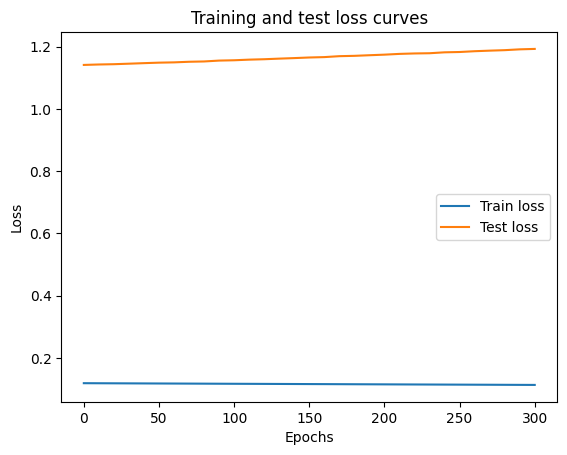

In [150]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()